In [1]:
import yaml

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.models import TFTacotron2
from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id

In [2]:
config = yaml.load(
    open("../examples/tacotron2/conf/tacotron2.v1.yaml"), Loader=yaml.Loader
)
config = Tacotron2Config(**config["tacotron2_params"])
processor = LJSpeechProcessor(None, "english_cleaners")

In [3]:
input_text = "i love you so much."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [4]:
tacotron2 = TFTacotron2(config=config, training=False, name="tacotron2")

In [5]:
tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(3000)

# Save to serialized protocol buffer

In [6]:
(decoder_output, mel_outputs, stop_token_prediction, alignments) = tacotron2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    input_lengths=tf.convert_to_tensor([len(input_ids)], tf.int32),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
)

In [7]:
tacotron2.load_weights("../examples/tacotron2/checkpoints/model-120000.h5", by_name=True)

In [8]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(tacotron2, "./test_saved", signatures=tacotron2.inference)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /ckpt/tacotron2/test_saved/assets


# Load and inference

In [9]:
tacotron2 = tf.saved_model.load("./test_saved")

In [10]:
input_text = "Unless you work on a ship, it's unlikely that you use the word boatswain in everyday conversation, so it's understandably a tricky one. The word - which refers to a petty officer in charge of hull maintenance is not pronounced boats-wain Rather, it's bo-sun to reflect the salty pronunciation of sailors, as The Free Dictionary explains."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [11]:
(decoder_output, mel_outputs, stop_token_prediction, alignments) = tacotron2.inference(
    tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    tf.convert_to_tensor([len(input_ids)], tf.int32),
    tf.convert_to_tensor([0], dtype=tf.int32),
)

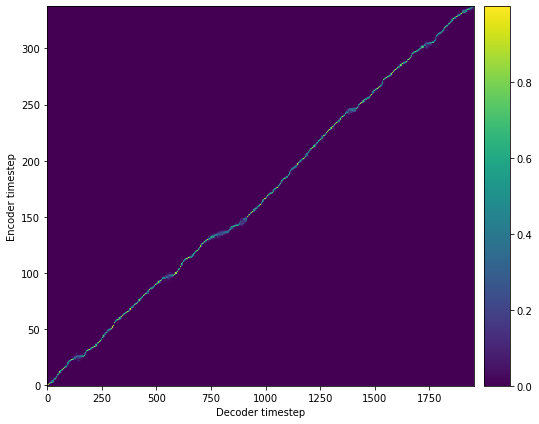

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(alignments[0], aspect="auto", interpolation="none", origin="lower")
fig.colorbar(im, pad=0.02, aspect=15, orientation="vertical", ax=ax)
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Encoder timestep")
plt.tight_layout()

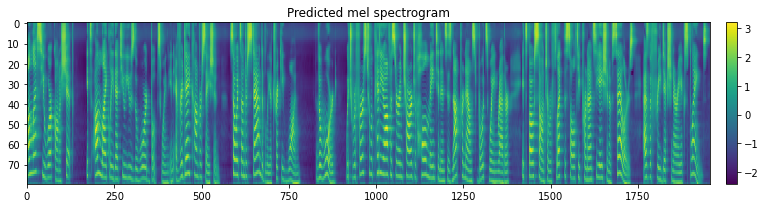

In [13]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(np.rot90(mel_outputs), aspect="auto", interpolation="none")
fig.colorbar(im, pad=0.02, aspect=15, orientation="vertical", ax=ax)
ax.set_title("Predicted mel spectrogram")
plt.tight_layout()

# Inference with input of different shapes

In [14]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)  # eos.

In [15]:
(decoder_output, mel_outputs, stop_token_prediction, alignments) = tacotron2.inference(
    tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    tf.convert_to_tensor([len(input_ids)], tf.int32),
    tf.convert_to_tensor([0], dtype=tf.int32),
)

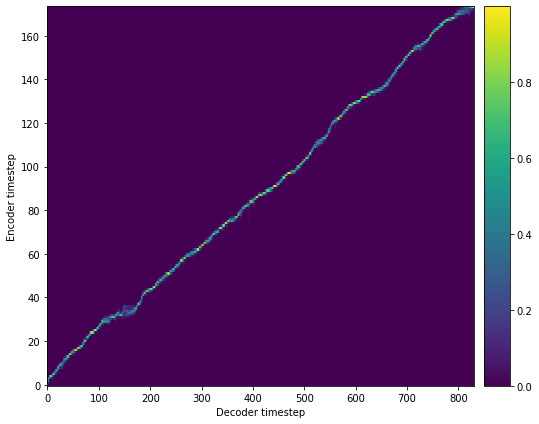

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(alignments[0], aspect="auto", interpolation="none", origin="lower")
fig.colorbar(im, pad=0.02, aspect=15, orientation="vertical", ax=ax)
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Encoder timestep")
plt.tight_layout()

Text(0.5, 1.0, 'Predicted mel spectrogram')

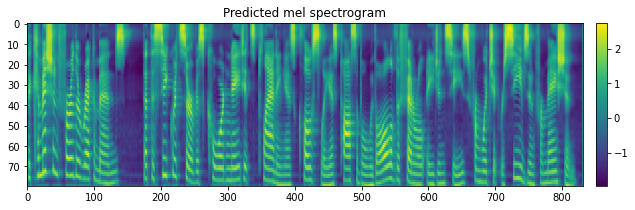

In [18]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(np.rot90(mel_outputs), aspect="auto", interpolation="none")
fig.colorbar(im, pad=0.02, aspect=15, orientation="vertical", ax=ax)
ax.set_title("Predicted mel spectrogram")
plt.tight_layout()